In [1]:
import sys
sys.path.append('../modules')

from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd


%load_ext autoreload
%autoreload 2

In [2]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/hdd/*.nc'
#PATH = '/home/nannau/Desktop/ensembles/jan1.0p/*'
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/jul2.5p/*.nc'

In [3]:
ds = read_data(PATH)
dv_field = ds['dv'].values.copy()
ens = ens_flat(dv_field)
rlat, rlon = ds['rlat'].values, ds['rlon'].values

In [4]:
irlon = np.linspace(np.min(rlon), np.max(rlon), rlon.shape[0]*10)
irlat = np.linspace(np.min(rlat), np.max(rlat), rlat.shape[0]*10)

rlon_ens = np.tile(rlon, rlat.shape[0])
rlat_ens = np.repeat(rlat, rlon.shape[0])

irlon_ens = np.tile(irlon, irlat.shape[0])
irlat_ens = np.repeat(irlat, irlon.shape[0])
icoordens = np.array(list(zip(irlon_ens, irlat_ens)))

coordens = np.array(list(zip(rlon_ens, rlat_ens)))

In [5]:
mask = load_land_mask('../data/mask.nc')
mask_master = mask_land_and_nan(dv_field, mask)
idx_ = mask_land_and_nan_ens_index(mask_master)
print(mask_master.shape)
#imask = np.tile(mask, (irlon.shape[0]*irlat.shape[0]))
mask_master = np.repeat(np.repeat(mask_master, 10, axis=1), 10) # honestly don't know how this works but it does
mask_master.shape
#idx = mask_land_and_nan_ens_index(mask_master)

(1, 130, 155)


(2015000,)

In [6]:
imask = np.expand_dims(np.reshape(mask_master, (irlat.shape[0], irlon.shape[0])), axis=0)
imask.shape
idx = mask_land_and_nan_ens_index(imask)
idx.shape, idx_.shape

((900500,), (9005,))

In [7]:
#fmask = interpolate.griddata(coordens, mask_master, icoordens, method = 'cubic', fill_value=False)

#imask = fmask.copy()
#imask = np.expand_dims(imask.astype(bool), axis=0)

#print(mask[0, ...].shape)

#plt.figure(figsize=(10, 10))
#plt.imshow(mask[0, ...], extent=[np.amin(rlon), np.amax(rlon), np.amin(rlat), np.amax(rlat)], cmap='cool', alpha=0.7)
#plt.imshow(imask, cmap='Greys', alpha=0.7)
#plt.gca().invert_yaxis()
#plt.savefig('/home/nannau/Desktop/maskpic.png')
#plt.show()

In [8]:
#idx = imask == True
#idx.shape
points = icoordens[idx]

In [9]:
iens = np.broadcast_to(np.reshape(imask, (irlon.shape[0]*irlat.shape[0])), (dv_field.shape[0], irlon.shape[0]*irlat.shape[0])).copy().astype(float)


In [10]:
points = icoordens[idx]

for i in range(dv_field.shape[0]):
    iens[i, idx] = interpolate.griddata(coordens[idx_], ens[i, idx_], points, method='linear')

iens.shape, ens.shape

((35, 2015000), (35, 20150))

In [11]:
nan_mask = np.apply_over_axes(
                np.logical_or.reduce,
                np.isnan(iens),
                (0)
)

master_idx = ~np.logical_or(~mask_master, nan_mask).flatten()

iens[:, master_idx]

array([[   10.98308465,    13.66069672,    16.33830879, ...,
        10243.15005025, 10124.91817583, 10006.68630141],
       [   10.7662496 ,    13.70578595,    16.64532229, ...,
        10366.17732043, 10248.04477426, 10129.91222809],
       [   15.32516275,    18.85221892,    22.3792751 , ...,
        10372.2394258 , 10254.94519835, 10137.6509709 ],
       ...,
       [   11.11249657,    13.80915245,    16.50580834, ...,
        10343.88098173, 10225.11712349, 10106.35326525],
       [   14.26176628,    17.58370564,    20.905645  , ...,
        10421.12560379, 10304.36044731, 10187.59529083],
       [   12.73326155,    15.94831946,    19.16337737, ...,
        10284.69433992, 10167.63702441, 10050.5797089 ]])

In [12]:
area = frac_grid_area(irlon, irlat)
area_relevent_grid_cells = area.reshape(1, -1)
area_relevent_grid_cells.shape

(1, 2015000)

In [13]:
mean = iens.mean(axis=0).reshape(1, -1)

In [14]:
corr_ens = (iens - mean)*area_relevent_grid_cells      
corr_ens = corr_ens[:, master_idx]

In [15]:
ens_eof = ens_to_eof(corr_ens).components_
#corr_ens_full_size[:ens_eof.shape[0], idx] = ens_eof

print("EOF Shape: ", ens_eof.shape)
type(ens_to_eof(corr_ens))

EOF Shape:  (12, 900325)


sklearn.decomposition.pca.PCA

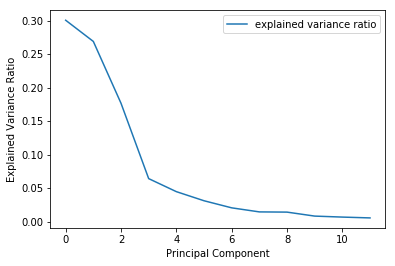

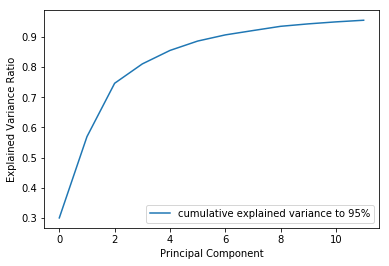

In [16]:
sns.lineplot(range(ens_eof.shape[0]), 
             ens_to_eof(corr_ens).explained_variance_ratio_, 
             label='explained variance ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
sns.lineplot(range(ens_eof.shape[0]), 
             np.cumsum(ens_to_eof(corr_ens).explained_variance_ratio_),
             label='cumulative explained variance to 95%')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [38]:
rcoord_ens_dict = rlat_rlon_to_ens(irlat, irlon)
rlat_ens = rcoord_ens_dict['rlat'][master_idx]
rlon_ens = rcoord_ens_dict['rlon'][master_idx]

lat_lon_ens = list(zip(rlat_ens, rlon_ens))
len(lat_lon_ens)

900325

In [18]:
df = pd.read_csv('../data/hdd_1991_2016', index_col=None)

In [19]:
df = df[df['completeness'] > 0.8]

In [20]:
lat_lon_obs = list(zip(df['lat'], df['lon']))
lat_obs, lon_obs = zip(*lat_lon_obs)

coords = to_rotated(lat_obs, lon_obs)
rlat_obs, rlon_obs = np.array(coords['rlat_obs']), np.array(coords['rlon_obs'])

lat_lon_obs = list(zip(rlat_obs, rlon_obs))

In [21]:
df['nearest_grid'] = dist_index(lat_lon_obs, lat_lon_ens)

In [24]:
ndf = df['hdd'].groupby(df['nearest_grid']).mean()


In [26]:
ndf.shape, df.shape

((580,), (597, 9))

In [27]:
match_ens_obs_idx = np.asarray(ndf.index)

In [28]:
match_obs_ens = np.array(ndf)*area_relevent_grid_cells[:, match_ens_obs_idx]
match_model_ens = ens_eof[:, match_ens_obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens[0, :].shape)

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (12, 580) 
Matched Obs shape:  (580,)


In [29]:
model = regress_eof(match_model_ens.T, match_obs_ens[0, :])

Regressed model score: 0.7993615286214194


In [30]:
predictions = predict_dv(model, ens_eof.T)

In [31]:
latlist, lonlist = zip(*list(lat_lon_ens))

In [32]:
observations = match_obs_ens/area_relevent_grid_cells[:, match_ens_obs_idx] 
reconstructed_observations = predictions[match_ens_obs_idx]/area_relevent_grid_cells[:, match_ens_obs_idx]

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.T, reconstructed_observations.T)

print("slope", regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.T)
# model evaluation
rmse = mean_squared_error(reconstructed_observations.T, y_predicted)
r2 = r2_score(reconstructed_observations.T, y_predicted)
print('EOF Score', model.score(match_model_ens.T, match_obs_ens[0, :]))
print('rmse', rmse)
print('r2 of linear fit', r2)

observations.T[:, 0]
np.polyfit(observations.T[:, 0], reconstructed_observations.T[:, 0], 1)

slope 0.7827858355865017
EOF Score 0.7993615286214194
rmse 305896.9258923873
r2 of linear fit 0.7828431347757614


array([7.82785836e-01, 9.41842333e+02])

Text(27.125, 0.5, 'Reconstruction')

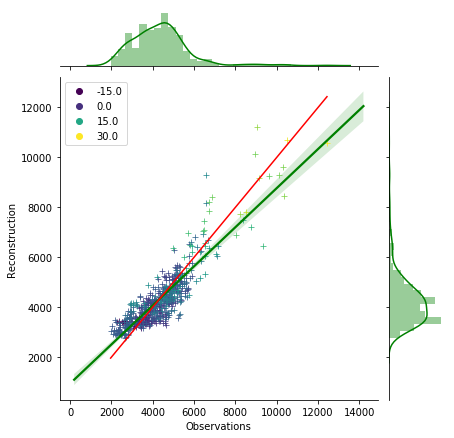

In [35]:
ax = sns.jointplot(observations.T[:, 0], reconstructed_observations.T[:, 0], kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(observations.T[:, 0], 
                reconstructed_observations.T[:, 0], 
                hue=rlat_ens[match_ens_obs_idx], 
                palette="viridis",
                marker='+'
)
sns.lineplot(observations.T[:, 0], 
             observations.T[:, 0], 
             color='r')
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

In [ ]:
# Now it's time to plot!
